In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
plt.style.use('fivethirtyeight')

# Read in datasets

In [2]:
crime = pd.read_csv('data/crime/crime.csv', low_memory=False)
crime.head()

,IncidentNum,ReportedDateTime,ReportedYear,ReportedMonth,Location,WeaponUsed,ALD,NSP,POLICE,TRACT,...,CriminalDamage,Homicide,LockedVehicle,Robbery,SexOffense,Theft,VehicleTheft,Total,Violent,Property
0,163020125,2016-10-28 19:55:00,2016,10,S 10TH ST / W GRANT ST,ROCK,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,2.0,0,2.0
1,163020126,2016-10-28 19:03:00,2016,10,7822 W CAPITOL DR,UNKNO,5.0,NaN,7.0,3400.0,...,1,0,0,0,0,0,0,2.0,0,2.0
2,163020129,2016-10-25 21:00:00,2016,10,6501 W OHIO AV,UNKNO,11.0,NaN,6.0,19800.0,...,0,0,1,0,0,0,0,2.0,0,2.0
3,163020130,2016-10-28 19:20:00,2016,10,2700 W KILBOURN AV,KNIFE,4.0,14.0,3.0,13600.0,...,0,0,0,1,0,0,0,4.0,2,2.0
4,163020131,2016-10-28 02:30:00,2016,10,3212 N 3RD ST,UNKNO,6.0,6.0,5.0,7000.0,...,0,0,0,0,0,0,1,2.0,0,2.0


In [3]:
### set date as datetime
crime.ReportedDateTime = pd.to_datetime(crime.ReportedDateTime)

Read in the weather data

In [4]:
weather_raw = pd.read_csv('data/weather/weather.csv')
weather_raw.head()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,USW00014839,"MILWAUKEE MITCHELL AIRPORT, WI US",2011-01-01,0.00,0.0,0.0,NaN,45.0,12.0
1,USW00014839,"MILWAUKEE MITCHELL AIRPORT, WI US",2011-01-02,0.00,0.0,0.0,NaN,25.0,12.0
2,USW00014839,"MILWAUKEE MITCHELL AIRPORT, WI US",2011-01-03,0.02,0.2,0.0,NaN,32.0,23.0
3,USW00014839,"MILWAUKEE MITCHELL AIRPORT, WI US",2011-01-04,0.00,0.1,0.0,NaN,29.0,11.0
4,USW00014839,"MILWAUKEE MITCHELL AIRPORT, WI US",2011-01-05,0.03,0.4,0.0,NaN,25.0,7.0


In [5]:
weather_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3844 entries, 0 to 3843
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  3844 non-null   object 
 1   NAME     3844 non-null   object 
 2   DATE     3844 non-null   object 
 3   PRCP     3843 non-null   float64
 4   SNOW     3841 non-null   float64
 5   SNWD     3839 non-null   float64
 6   TAVG     3023 non-null   float64
 7   TMAX     3843 non-null   float64
 8   TMIN     3843 non-null   float64
dtypes: float64(6), object(3)
memory usage: 270.4+ KB


In [6]:
## fill NAs with zero
weather = weather_raw.copy(deep=True).fillna(0.0)

In [7]:
# convert date to datetime
weather.DATE = pd.to_datetime(weather.DATE)

In [8]:
# Group data at weekly level
weather_week = weather.set_index('DATE').resample('W').mean()[['PRCP', 'SNOW', 'SNWD', 'TMAX']]

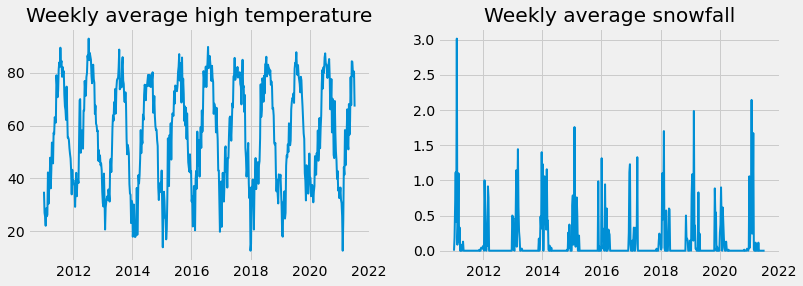

In [9]:
## making sure the data makes sense
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(weather_week.TMAX, lw=2)
plt.title('Weekly average high temperature')

plt.subplot(1,2,2)
plt.plot(weather_week.SNOW, lw=2)
plt.title('Weekly average snowfall')
plt.show()

**Join this with the crime data**

In [10]:
### first, narrow crime data to the same range (starting in 6/1/2016)
print(weather.DATE.min())
print(weather.DATE.max())
print(crime.ReportedDateTime.max())

2011-01-01 00:00:00
2021-07-10 00:00:00
2021-07-09 06:30:00


To make sure we have enough data to model seasonality, we'll go back to 2012. And we'll cut off data at 7/3, since the following week of weather data wasn't a full week

In [11]:
crime_ts = crime[(crime.ReportedDateTime>='2012-01-01') &\
                 (crime.ReportedDateTime<='2021-07-03')]

crime_ts = crime_ts.rename(columns={'ReportedDateTime': 'DATE'})

In [12]:
### now resample to weekly level
crime_week_ts = crime_ts.set_index('DATE').resample('W').sum()\
                    [['Homicide', 'Violent', 'Property', 'VehicleTheft']]
crime_week_ts.tail()

,Homicide,Violent,Property,VehicleTheft
DATE,,,,
2021-06-06,6,347,512.0,182
2021-06-13,7,388,661.0,247
2021-06-20,2,336,562.0,193
2021-06-27,1,275,421.0,103
2021-07-04,3,123,149.0,29


In [13]:
### merge in weather data
print(len(crime_week_ts))
crime_week_ts = crime_week_ts.merge(weather_week, left_index=True, right_index=True)
print(len(crime_week_ts))
crime_week_ts.head()

497
497


,Homicide,Violent,Property,VehicleTheft,PRCP,SNOW,SNWD,TMAX
DATE,,,,,,,,
2012-01-01,1,72,67.0,11,0.111429,0.071429,0.000000,39.428571
2012-01-08,4,237,629.0,83,0.000000,0.000000,0.142857,37.857143
2012-01-15,1,214,553.0,73,0.058571,1.000000,2.571429,37.142857
2012-01-22,0,191,496.0,71,0.068571,0.642857,4.000000,29.285714
2012-01-29,1,221,538.0,53,0.051429,0.328571,0.714286,36.571429


In [14]:
### the first week is clearly incomplete, so let's remove it
crime_week_ts = crime_week_ts.iloc[1:]

In [15]:
crime_week_ts.tail()

,Homicide,Violent,Property,VehicleTheft,PRCP,SNOW,SNWD,TMAX
DATE,,,,,,,,
2021-06-06,6,347,512.0,182,0.002857,0.0,0.0,84.285714
2021-06-13,7,388,661.0,247,0.005714,0.0,0.0,84.142857
2021-06-20,2,336,562.0,193,0.121429,0.0,0.0,80.000000
2021-06-27,1,275,421.0,103,0.108571,0.0,0.0,78.571429
2021-07-04,3,123,149.0,29,0.082857,0.0,0.0,80.428571


**Since we know vehicle thefts have had an anomolous pattern since the pandemic, I'll also create an "other" property crime column that excludes it.**

In [16]:
crime_week_ts['PropertyOther'] = crime_week_ts.Property - crime_week_ts.VehicleTheft

# Evaluate relationship between weather predictors and crime

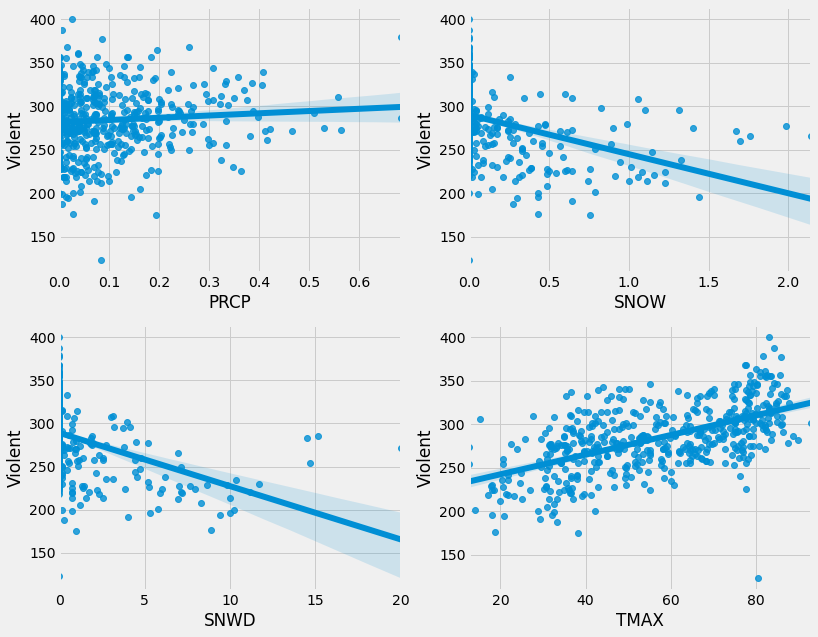

In [17]:
# Start with violient
plt.figure(figsize=(12,10))
plt.subplot(2,2,1); sns.regplot(data=crime_week_ts, x='PRCP', y='Violent')
plt.subplot(2,2,2); sns.regplot(data=crime_week_ts, x='SNOW', y='Violent')
plt.subplot(2,2,3); sns.regplot(data=crime_week_ts, x='SNWD', y='Violent')
plt.subplot(2,2,4); sns.regplot(data=crime_week_ts, x='TMAX', y='Violent')
plt.show()

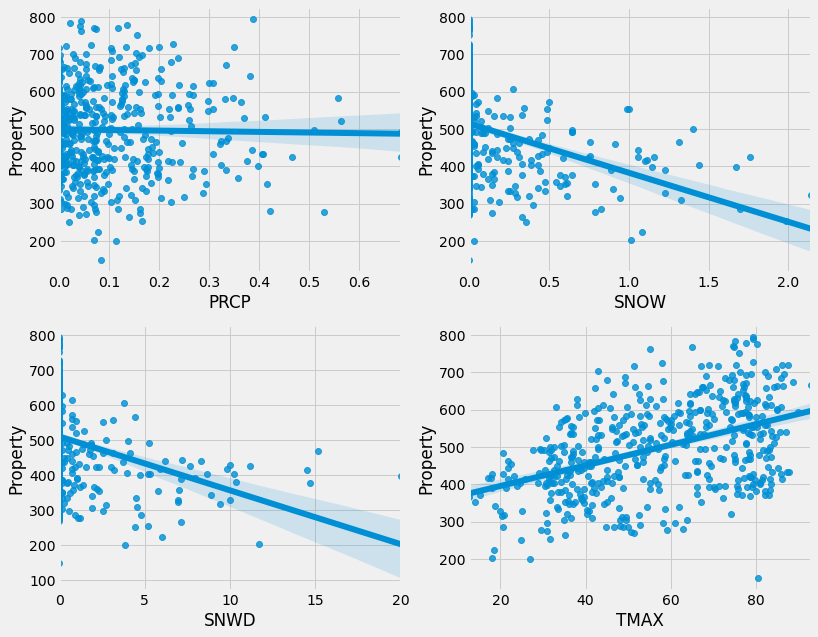

In [18]:
# Now property
plt.figure(figsize=(12,10))
plt.subplot(2,2,1); sns.regplot(data=crime_week_ts, x='PRCP', y='Property')
plt.subplot(2,2,2); sns.regplot(data=crime_week_ts, x='SNOW', y='Property')
plt.subplot(2,2,3); sns.regplot(data=crime_week_ts, x='SNWD', y='Property')
plt.subplot(2,2,4); sns.regplot(data=crime_week_ts, x='TMAX', y='Property')
plt.show()

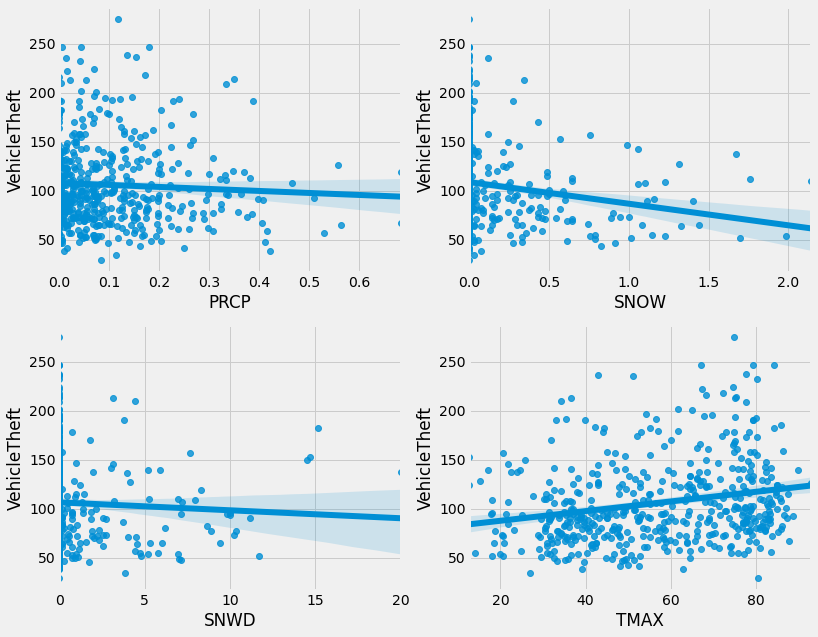

In [19]:
# Now car thefts
plt.figure(figsize=(12,10))
plt.subplot(2,2,1); sns.regplot(data=crime_week_ts, x='PRCP', y='VehicleTheft')
plt.subplot(2,2,2); sns.regplot(data=crime_week_ts, x='SNOW', y='VehicleTheft')
plt.subplot(2,2,3); sns.regplot(data=crime_week_ts, x='SNWD', y='VehicleTheft')
plt.subplot(2,2,4); sns.regplot(data=crime_week_ts, x='TMAX', y='VehicleTheft')
plt.show()

# Decompose time series

All of these clearly have seasonal and trend components to them.

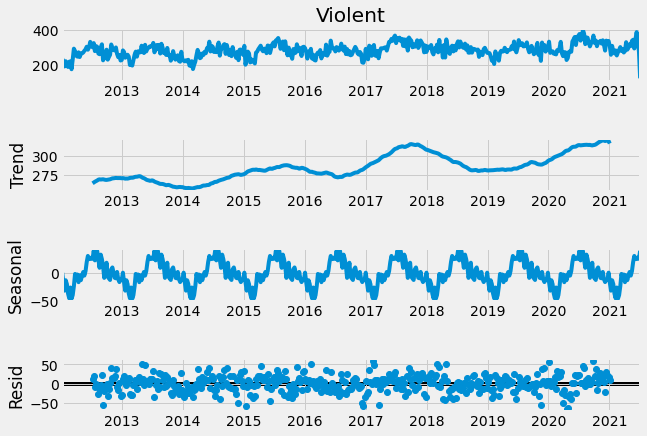

In [20]:
seas=sm.tsa.seasonal_decompose(crime_week_ts.Violent,
                               model='additive',period=52)

fig=seas.plot()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.show()

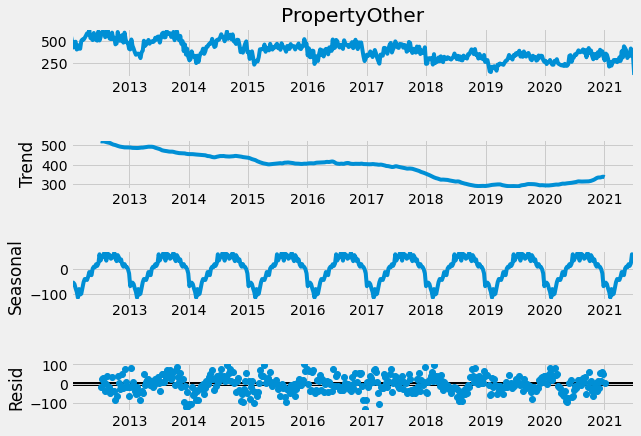

In [21]:
seas=sm.tsa.seasonal_decompose(crime_week_ts.PropertyOther,
                               model='additive',period=52)

fig=seas.plot()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.show()

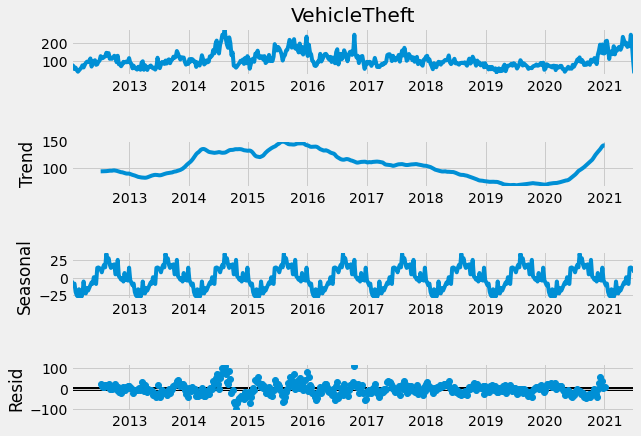

In [22]:
seas=sm.tsa.seasonal_decompose(crime_week_ts.VehicleTheft,
                               model='additive',period=52)

fig=seas.plot()
fig.set_figwidth(10)
fig.set_figheight(7)
plt.show()

Also clear that differencing is needed to make the data stationary. Making ACF/PACF plots below just to further confirm that ARIMA approach (though exogenous weather vars will also be added) is appropriate

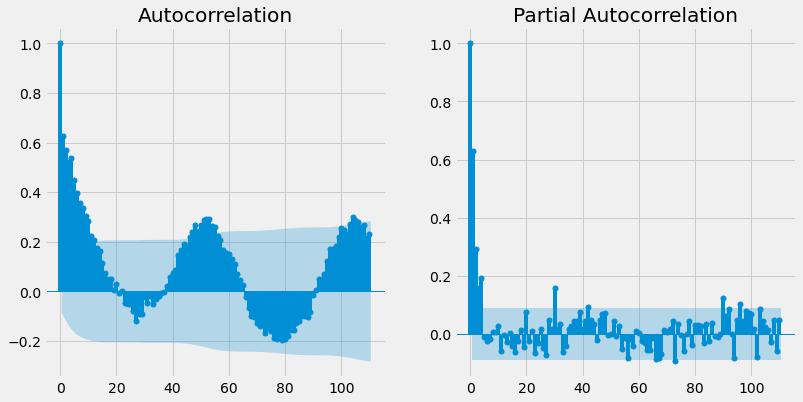

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
plot1 = sm.graphics.tsa.plot_acf(crime_week_ts.Violent,
                                 lags=110, lw=1, ax=axes[0])
plot2 = sm.graphics.tsa.plot_pacf(crime_week_ts.Violent,
                                  lags=110, lw=1, ax=axes[1])

Above plot suggests at least MA model. Can clearly tell seasonality not accounted for in PACF plot. After first-order differencing (below), the tapering pattern in the PACF plot makes me think AR also worth testing. We will test a variety of parameters during cross validation.

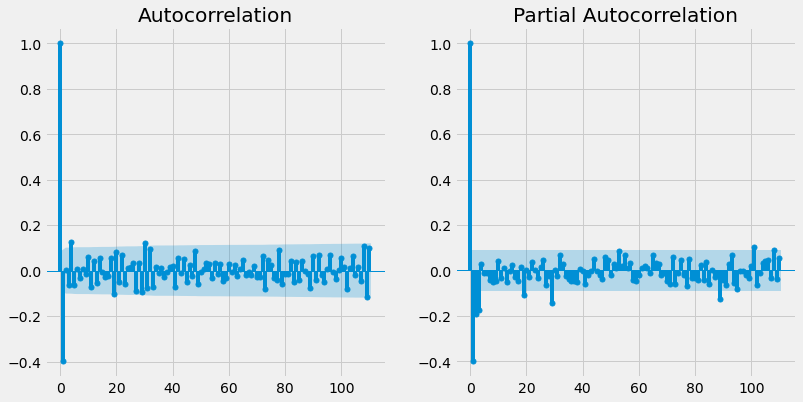

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
plot1 = sm.graphics.tsa.plot_acf(crime_week_ts.Violent.diff()[1:],
                                 lags=110, lw=1, ax=axes[0])
plot2 = sm.graphics.tsa.plot_pacf(crime_week_ts.Violent.diff()[1:],
                                  lags=110, lw=1, ax=axes[1])

# Use cross-validation to find model params that minimize forecast error.

In [25]:
###, first, split off pre-pandemic data
train = crime_week_ts[:'2020-03-24']
test = crime_week_ts['2020-03-25':]

### drop last row of test, which is incomplete week
test = test[:-1]

Forecasting just one step ahead isn't very interesting for our purposes, so I'll use will use 8-step (two months) ahead forecasting during cross-validation

In [26]:
splits = [len(train)-8* i for i in range(11)][::-1]
print(splits)

[349, 357, 365, 373, 381, 389, 397, 405, 413, 421, 429]


In [27]:
def cross_validation(train, y, params, best_params, best_mse , model=0):
    
    train_idx = 0
    val_idx = 1

    start = time.time()

    ### loop through p, d, q params
    for p in params['order']['p']:
        for q in params['order']['q']:
            for P in params['s_order']['P']:
                for Q in params['s_order']['Q']:
                    model +=1
                    print('\nFitting model {} of {}; order: {}, 1, {}, s_order: {}, 1, {}'\
                         .format(model, 36, p, q, P, Q))

                    temp_mae = []
                    temp_mse = []

                    for i in range(10):
                        print('Model: {}; Iterating over split: {}, train idx ending at: {}; val idxs {}: {}\n'.\
                              format(model, i+1, splits[train_idx], splits[train_idx], splits[val_idx]))

                        X_tr = train.iloc[:splits[train_idx]]
                        X_val = train.iloc[splits[train_idx]:splits[val_idx]]
                        y_val = train.iloc[splits[train_idx]:splits[val_idx]][y].values

                        mod = sm.tsa.statespace.SARIMAX(X_tr[y],
                                trend='c',
                                order=(p, 1, q),
                                seasonal_order=(P, 1, Q, 52),
                                exog=X_tr[['TMAX', 'SNOW', 'PRCP']],
                                max_iter=500)
                        res = mod.fit(disp=False)

#                             print('train and val idx for pred', splits[train_idx], splits[val_idx]-1)
                        preds = res.forecast(steps=8, exog = X_val[['TMAX', 'SNOW', 'PRCP']])

                        error = np.abs(preds - y_val)
                        mse = np.mean(error**2)
                        mae = np.mean(error)

                        ### append results
                        temp_mae.append(mae)
                        temp_mse.append(mse)

                        ### incrememnt idxs
                        val_idx+=1
                        train_idx+=1

                    print('\nTime lapsed:', (time.time() - start) / 60)

                    ### reset idxs to 0
                    train_idx = 0
                    val_idx = 1

                    mean_mae = np.mean(temp_mae)
                    mean_mse = np.mean(temp_mse)

                    print(mean_mse, best_mse)
                    if mean_mse < best_mse:
                        best_mse = mean_mse
                        print('NEW BEST PARAMS')
                        best_params['order'] = [p,1,q]
                        best_params['s_order'] = [P,1,Q]
                        best_params['scores'] = [mean_mae, mean_mse]

                    print('Results for order: {}, 1, {}, s_order: {}, 1 {}'\
                         .format(p, q, P, Q))
                    print('MSE: {}; MAE: {}\n'.format(mean_mse, mean_mae))


    print(best_params)
    return best_params, best_mse

In [28]:
import time

# set up params
params = {
    'order': {
        'p': [0,1],
        'd': [1],
        'q': [0,1]
    },
    's_order': {
        'P': [0,1,2],
        'D': [1],
        'Q': [0,1,2]
    }
}

violent_best_mse = 10000000
violent_best_params = {'order': None, 's_order': None, 'scores': None}

property_best_mse = 10000000
property_best_params = {'order': None, 's_order': None, 'scores': None}

autotheft_best_mse = 10000000
autotheft_best_params = {'order': None, 's_order': None, 'scores': None}

## Start with violent crime data

In [29]:
%%time
violent_params, violent_best_mse = cross_validation(train, 'Violent', params, violent_best_params, violent_best_mse)

Best params: {'order': [0, 1, 1], 's_order': [0, 1, 1], 'scores': [15.936386761085126, 408.3086486807222]}

## Now property crime data

In [30]:
%%time
property_params, property_best_mse = cross_validation(train, 'PropertyOther', params, property_best_params, property_best_mse)

Best params: {'order': [1, 1, 1], 's_order': [2, 1, 0], 'scores': [33.37786295689394, 1799.0445285848284]}

## Now vehicle thefts

In [31]:
%%time
autotheft_best_params, autotheft_best_mse = cross_validation(train, 'VehicleTheft', params, autotheft_best_params, autotheft_best_mse)

Best params: {'order': [1, 1, 1], 's_order': [0, 1, 1], 'scores': [16.852669159841263, 402.2210650504313]}

# Plot actual vs. expected crime

Use param values identified during cross validation to fit final models for each crime category, and then forecast test period

In [30]:
vMod = sm.tsa.statespace.SARIMAX(train.Violent,
                                    trend='c',
                                    order=(0, 1, 1),
                                    seasonal_order=(0, 1, 1, 52),
                                    exog=train[['TMAX', 'SNOW', 'PRCP']],
                                    max_iter=500)
vRes = vMod.fit(disp=False)
vPreds = vRes.predict()
vForecast = vRes.forecast(steps=52, exog=test[['TMAX', 'SNOW', 'PRCP']][:52])

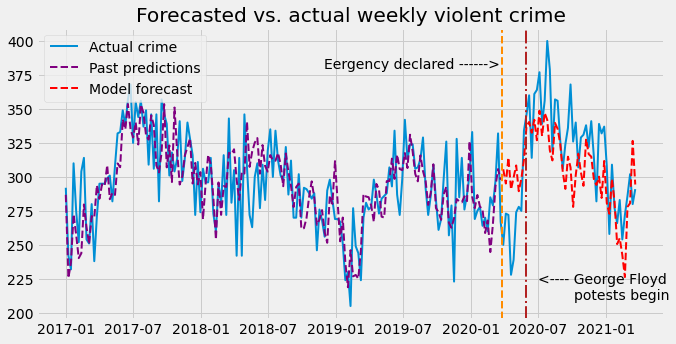

In [56]:
import datetime as dt
plt.figure(figsize=(10,5))
plt.plot(train['2017':].Violent.append(test[:52].Violent), label='Actual crime', lw=2)
plt.plot(vPreds['2017':], color='purple', ls='--', label='Past predictions', lw=2)
plt.plot(vForecast, color='red', ls='--', label='Model forecast', lw=2)
plt.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
plt.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
plt.annotate('Eergency declared ------>', (dt.datetime(2018, 12, 1), 380))
plt.annotate('<---- George Floyd\n        potests begin', (dt.datetime(2020, 7, 1), 210))
plt.legend(loc='upper left')
plt.title('Forecasted vs. actual weekly violent crime')
plt.show()

In [37]:
pMod = sm.tsa.statespace.SARIMAX(train.PropertyOther,
                                    trend='c',
                                    order=(1, 1, 1),
                                    seasonal_order=(2, 1, 0, 52),
                                    exog=train[['TMAX', 'SNOW', 'PRCP']],
                                    max_iter=500)
pRes = pMod.fit(disp=False)
pPreds = pRes.predict()
pForecast = pRes.forecast(steps=52, exog=test[:52][['TMAX', 'SNOW', 'PRCP']])

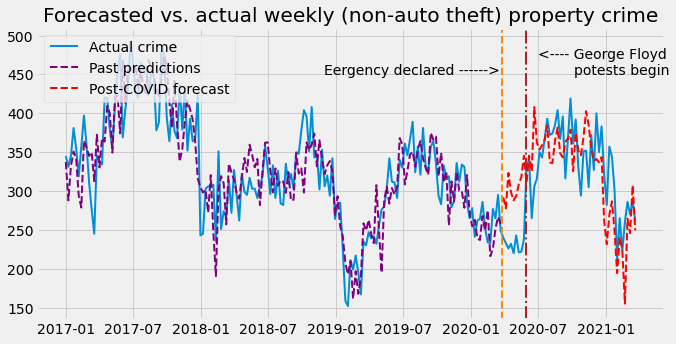

In [58]:
plt.figure(figsize=(10,5))
plt.plot(train['2017':].PropertyOther.append(test[:52].PropertyOther), label='Actual crime', lw=2)
plt.plot(pPreds['2017':], color='purple', ls='--', label='Past predictions', lw=2)
plt.plot(pForecast, color='red', ls='--', label='Post-COVID forecast', lw=2)
plt.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
plt.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
plt.annotate('Eergency declared ------>', (dt.datetime(2018, 12, 1), 450))
plt.annotate('<---- George Floyd\n        potests begin', (dt.datetime(2020, 7, 1), 450))
plt.legend(loc='upper left')
plt.title('Forecasted vs. actual weekly (non-auto theft) property crime')
plt.show()

In [39]:
aMod = sm.tsa.statespace.SARIMAX(train.VehicleTheft,
                                    trend='c',
                                    order=(1, 1, 1),
                                    seasonal_order=(0, 1, 1, 52),
                                    exog=train[['TMAX', 'SNOW', 'PRCP']],
                                    max_iter=5000)
aRes = aMod.fit(disp=False)
aPreds = aRes.predict()
aForecast = aRes.forecast(steps=len(test[:52]), exog=test[:52][['TMAX', 'SNOW', 'PRCP']])

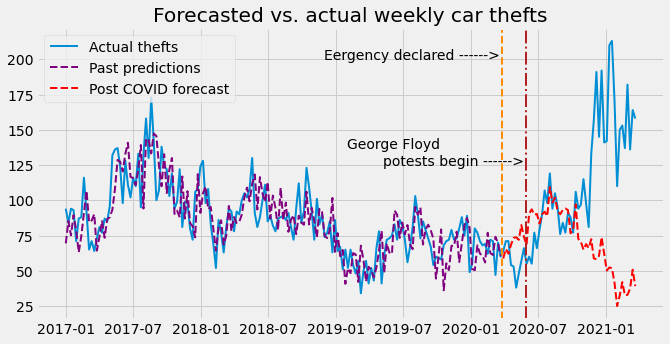

In [63]:
plt.figure(figsize=(10,5))
plt.plot(train['2017':].VehicleTheft.append(test[:52].VehicleTheft), label='Actual thefts', lw=2)
plt.plot(aPreds['2017':], color='purple', ls='--', label='Past predictions', lw=2)
plt.plot(aForecast, color='red', ls='--', label='Post COVID forecast', lw=2)
plt.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
plt.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
plt.annotate('Eergency declared ------>', (dt.datetime(2018, 12, 1), 200))
plt.annotate('George Floyd\n        potests begin ------>', (dt.datetime(2019, 2, 1), 125))
plt.legend(loc='upper left')
plt.title('Forecasted vs. actual weekly car thefts')
plt.show()

What if the forecast is extended further?

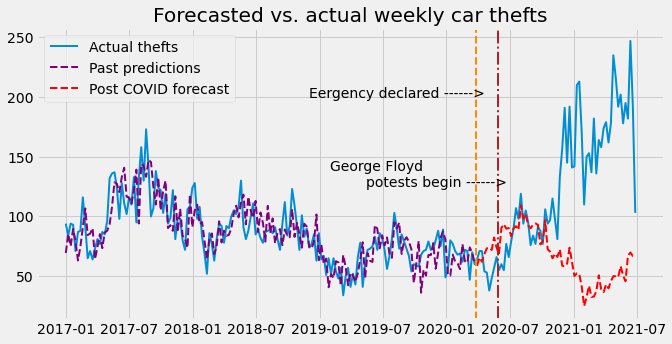

In [65]:
aForecast = aRes.forecast(steps=len(test), exog=test[['TMAX', 'SNOW', 'PRCP']])
plt.figure(figsize=(10,5))
plt.plot(train['2017':].VehicleTheft.append(test.VehicleTheft), label='Actual thefts', lw=2)
plt.plot(aPreds['2017':], color='purple', ls='--', label='Past predictions', lw=2)
plt.plot(aForecast, color='red', ls='--', label='Post COVID forecast', lw=2)
plt.axvline(pd.to_datetime('2020-03-25'), color='darkorange', lw=2, ls='--')
plt.axvline(pd.to_datetime('2020-05-29'), color='firebrick', lw=2, ls='-.')
plt.annotate('Eergency declared ------>', (dt.datetime(2018, 12, 1), 200))
plt.annotate('George Floyd\n        potests begin ------>', (dt.datetime(2019, 2, 1), 125))
plt.legend(loc='upper left')
plt.title('Forecasted vs. actual weekly car thefts')
plt.show()

# Calculate pct. above expected for each category

In [41]:
test_year = test[:52].copy(deep=True)

In [42]:
test_year['Violent_predicted'] = vForecast.values
test_year['PropertyOther_predicted'] = pForecast.values
test_year['VehicleTheft_predicted'] = aForecast.values

In [45]:
summary = pd.DataFrame(columns=['Crime', 'Prior Year Total', 'Current forecasted', 'Current actual',
                                'Pct. above forecast', 'Pct. above prior year'])

for i, crime in enumerate(['Violent', 'PropertyOther', 'VehicleTheft']):
    prior_year = train[-52:][crime].sum()
    forecasted = int(test_year[crime + '_predicted'].sum().round())
    actual = test_year[crime].sum()
    pct_above_fcast = np.round((((actual - forecasted) / forecasted) * 100),2)
    pct_above_lyear = np.round((((actual - prior_year) / prior_year) * 100),2)
    summary.loc[i] = [crime, prior_year, forecasted, actual,
                      pct_above_fcast, pct_above_lyear]
summary

,Crime,Prior Year Total,Current forecasted,Current actual,Pct. above forecast,Pct. above prior year
0,Violent,15177,15839,16337,3.14,7.64
1,PropertyOther,15673.0,16626,16375.0,-1.51,4.48
2,VehicleTheft,3620,3658,5590,52.82,54.42
